# Lets train deep NN




In [1]:
#Lets train deeper nn
import torch
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:

words = open('names.txt', 'r').read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [3]:

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocabSiz = len(itos)
print(itos)
print(vocabSiz)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
def buildDataset(words):
    blocksiz = 3
    X, Y = [], []
    for w in words:
        contxt = [0] * blocksiz
        for ch in w + '.':
            ix = stoi[ch]
            X.append(contxt)
            Y.append(ix)
            contxt = contxt[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xTrain, yTrain = buildDataset(words[:n1])
xDev, yDev = buildDataset(words[n1:n2])
xTst, yTst = buildDataset(words[n2:])




#BatchNoram1d

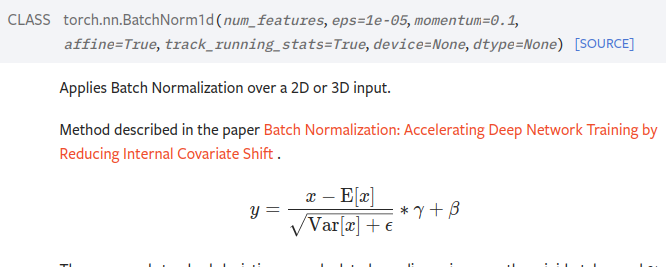

#Normalization ,BatchNorm:
     * Typicaly Normalizing process consists of scaling The Neumaric data Down to 0--->1
     * in standard Norm Process, Subtract Mean of Data set From each Data poing
          + z = datapoing - Mean / STD
     * This force to standard Data to take an Mean of Zero0 and STD of one1
     * in practic this stardrd Proces refer As Normalization as well

### When Apply batchnorm to layer, Normalize Output from Activation Funcs
      z = dataPoing - Mean / Std

     * after that batch Norm will mul this norm output by artbity para[Gamma], and then aadd antoher arbitry para[Beta] to this result
     z = z*gamma + beta

     *  Those cal would give new Mean and STD
    
### * Normaliz happen to data before passed into Input Layer

### * Now with this BatchNorm we can normalize the Output from the activation function for Individual layers


# Variables::
  1. Class Linear:
    * Why use fanIn, fanOUt
        + fan-in and fan-out refer to the layer's structure and serve to guide the **initialization of weights**, which affects the model's performance and stability.

        + **fan-in**
           *  This is the number of input units (or neurons) feeding into a layer.
        
        + **fan-out**
           *  This is the number of output units (or neurons) that each neuron in the current layer will feed into in the next layer.
    * **self.weights** =  A matrix initialized with random values, scaled by fanIn to help normalize the input

    * **self.biase** = A vector of zeros (or None if biase=False) that adds a bias term to each output, enabling the model to ***fit data better by allowing for non-zero output when inputs are zero.***


  2. Class BatchNorm1d:
     * **batch normalization** is applied to** stabilize the learning process **by n**ormalizing each batch of inputs.  **

     + **eps (epsilon):**: A small constant (e.g., 1e-5) added to the variance in the normalization step to **avoid division by zero and to ensure numerical stability.**

     + ** moment (momentum):** Determines the rate at which the running mean and variance are updated during training. A smaller value makes updates slower, relying more on the previous values. This allows for a s**table estimate of mean and variance** over time.

     + **gamma:** A learnable scaling factor applied after normalization. It allows the network to "re-scale" the normalized output, giving flexibility to maintain the expressive power of the network.
     
     + **beta: ** A learnable shift parameter (initialized as zeros). After normalization and scaling by gamma, **beta shifts the output**. This adds flexibility for the network to shift the normalized data.
    

In [5]:

blocksiz = 3
nEmb = 10 # dim  of char embedding vectors
nHidden = 100
g = torch.Generator().manual_seed(2147483647)


In [33]:


class Linear:
    def __init__(self, fanIn, fanOut, biase=True):
        self.weights = torch.randn((fanIn, fanOut), generator=g) / fanIn**0.5
        self.biase = torch.zeros(fanOut) if biase else None

    def __call__(self, x):
        self.out = x @ self.weights

        if self.biase is not None:
            self.out += self.biase
        return self.out

    def para(self):#parameters
        return [self.weights] + ([ ] if self.biase is None else [self.biase])

class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, moment=0.1):
        self.eps = eps
        self.moment = moment
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.runningMean = torch.zeros(dim)
        self.runningVariance = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xMean = x.mean(0, keepdim=True)
            xVariance = x.var(0, keepdim=True)
        else:
            xMean = self.runningMean
            xVariance = self.runningVariance

        xHat = (x - xMean) / torch.sqrt(xVariance +  self.eps) #Normlize Unit Varianc
        self.out = self.gamma * xHat + self.beta

        if self.training:
            with torch.no_grad():
                self.runningMean = (1 - self.moment) * self.runningMean + self.moment * xMean
                self.runningVariance = (1 - self.moment) * self.runningVariance + self.moment * xVariance

        return self.out

    def para(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def para(self):
        return [ ]



# NN with 6 Layers with tanh Activation and Batchnorm1d

In [34]:
#C = torch.randn((vocabSiz, nEmb), generator=g)
#layers = [
#  Linear(nEmb * blocksiz, nHidden),    Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, vocabSiz),
#]

C = torch.randn((vocabSiz, nEmb), generator=g)
layers = [
  Linear(nEmb * blocksiz, nHidden), BatchNorm1D(nHidden), Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1D(nHidden), Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1D(nHidden), Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1D(nHidden) ,Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1D(nHidden), Tanh(),
  Linear(           nHidden, vocabSiz), BatchNorm1D(vocabSiz)
]

 + becuas the last leyer is batchnorm we would not be** changing the weights**
 to make softmak less Confidence
     * layers[-1].weight *= 0.1
     * Use--> Gamma layers[-1].gamma *= 0.1
 + Why Use gamma insted weights::
     * becuas gamma is the variable in Batchnorm That mul interact with the output
     of that normalization

In [35]:

with torch.no_grad():
    #last Layer:: make Less Confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    #all other layers apply Gain
    for layr in layers[:-1]:
        if isinstance(layr, Linear):
            layr.weights  *= 5/3


In [36]:

para = [C] + [p for layr in layers for p in layr.para()]
print(sum(p.nelement() for p in para))
for p in para:
    p.requires_grad = True


47551


In [37]:
maxSteps = 200000
batchSiz = 32
loss_i = []
ud = [] #update to data Ratio

for i in range(maxSteps):
    #minibatch Construct
    ix = torch.randint(0, xTrain.shape[0], (batchSiz,), generator=g)
    Xb, Yb = xTrain[ix], yTrain[ix] #batch x/y

    #forwardPass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) #construct vec
    for lyr in layers:
        x = lyr(x)
    loss = F.cross_entropy(x, Yb) #loss Func

    #backward Pass
    for lyr in layers:
        lyr.out.retain_grad() #AFTER DEBGU; would takeout retain graph

    for p in para:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    if i % 10000 == 0: #print evry once in a while
        print(f'{i:7d}/{maxSteps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in para])

    if i > 2000:
        break



      0/ 200000: 3.3105


#STATS

  1. STD[Standard Deviation]:
        + this tells us **How Wider the Curve** Should be
        and the wider the curve The lower and Narrow the Curve The Higher[some qty]
  
  2. Mean:
        + Sum of measuerment / the Num of the Measurment
        
        * also ther's:
            + Population Mean
            + Estimated Population Mean
   
   3. Variance:
        The popultion Variance is the Avg of SquareRoot defferent Between Data and Population Mean
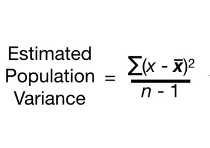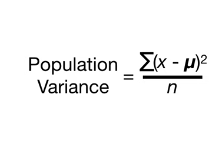
        

layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.06%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.94%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.88%
layer 11 (      Tanh): mean +0.02, std 0.66, saturated: 1.91%
layer 14 (      Tanh): mean +0.02, std 0.66, saturated: 1.56%


Text(0.5, 1.0, 'activation distribution')

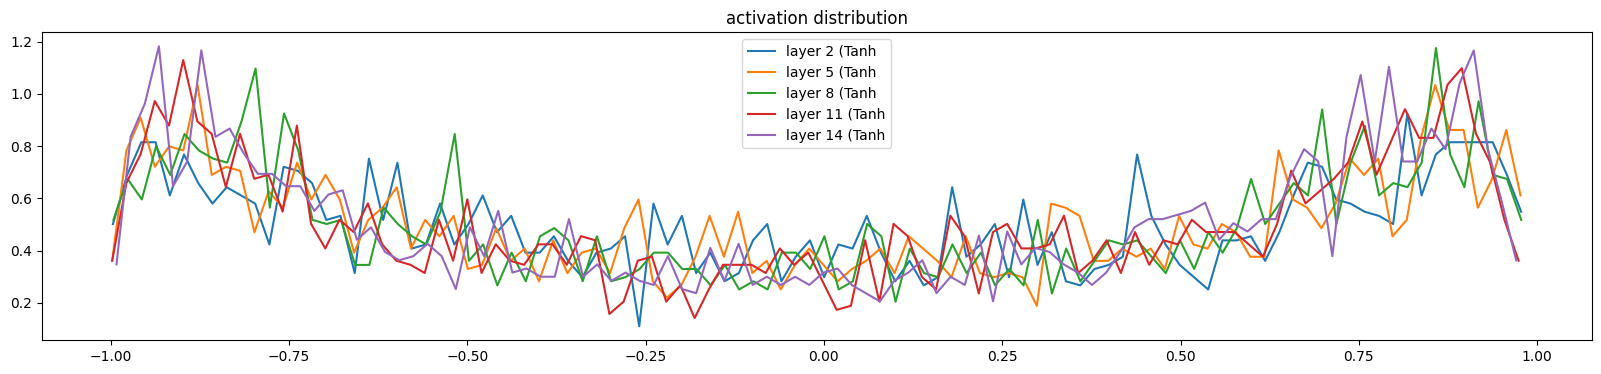

In [38]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (
        i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100
    ))

    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#Gradient Dist

layer 2 (      Tanh): mean -0.000000, std 3.570508e-03
layer 5 (      Tanh): mean -0.000000, std 3.039162e-03
layer 8 (      Tanh): mean +0.000000, std 2.958046e-03
layer 11 (      Tanh): mean +0.000000, std 2.825749e-03
layer 14 (      Tanh): mean +0.000000, std 3.195654e-03


Text(0.5, 1.0, 'gradient distribution')

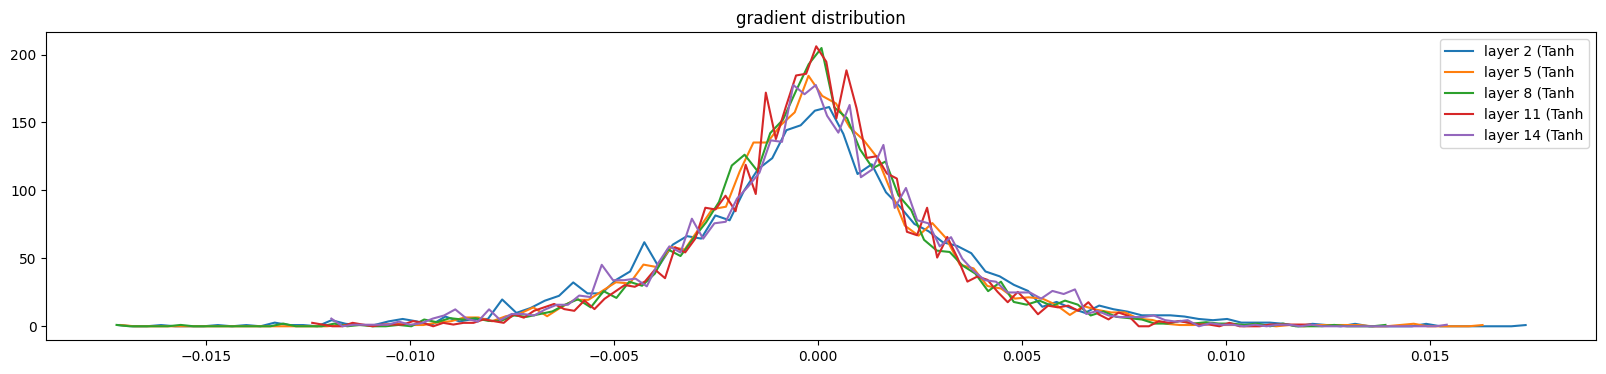

In [23]:
# visualize histograms 1.0
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.722466e-03 | grad:data ratio 7.544272e-03
weight  (30, 100) | mean +0.000080 | std 6.424164e-03 | grad:data ratio 1.228914e-02
weight (100, 100) | mean +0.000017 | std 3.961768e-03 | grad:data ratio 1.268096e-02
weight (100, 100) | mean -0.000015 | std 3.869142e-03 | grad:data ratio 1.265385e-02
weight (100, 100) | mean +0.000034 | std 3.869226e-03 | grad:data ratio 1.302394e-02
weight (100, 100) | mean +0.000001 | std 3.446740e-03 | grad:data ratio 1.224538e-02
weight  (100, 27) | mean -0.000189 | std 5.978259e-03 | grad:data ratio 1.347912e-02


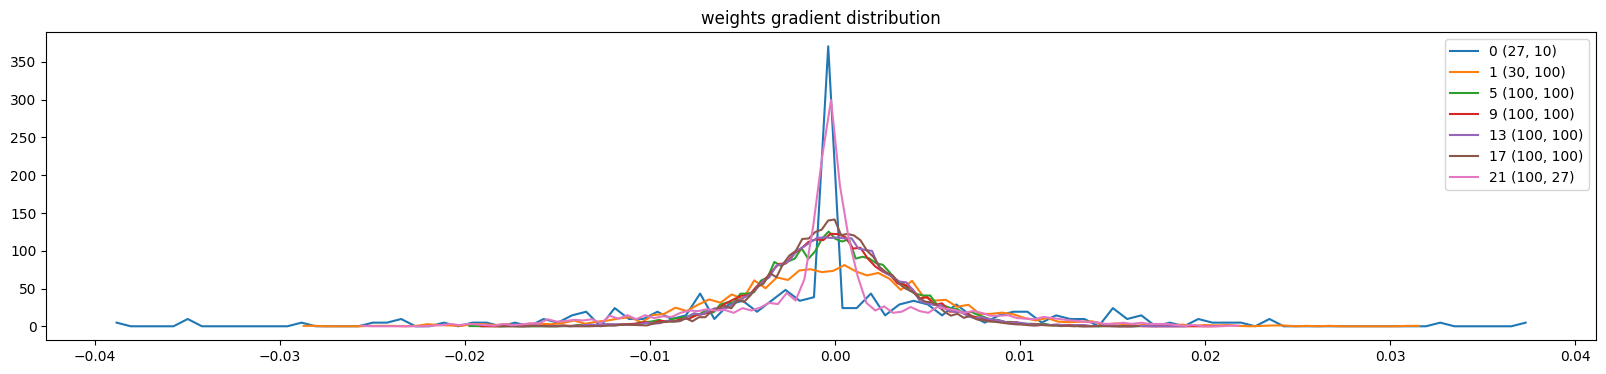

In [24]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(para):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

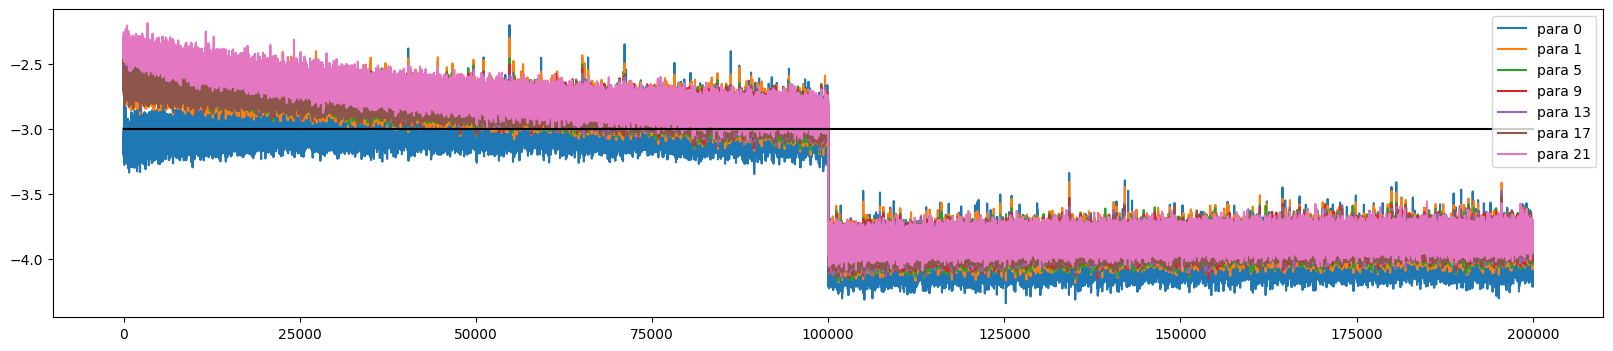

In [25]:

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(para):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('para %d' % i)
plt.plot([0, len(ud)],  [-3, -3], 'k')
plt.legend(legends);

In [39]:

@torch.no_grad()
def splitLoss(split):
    x, y = {
        'train': (xTrain, yTrain),
        'dev': (xDev, yDev),
        'test': (xTst, yTst)
    }[split]

    emb = C[x]
    x =  emb.view(emb.shape[0], -1)
    for lyr in layers:
        x = lyr(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

#put layers into eval mode
for lyr in layers:
    lyr.training = False


splitLoss('train')
splitLoss('dev')

train 2.3217334747314453
dev 2.3205173015594482
